In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gdown
import kagglehub
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor

# Helper Functions

In [304]:
def fetch_dataset(key, dataset_name):
    cmd = !gdown --fuzzy {key} -O {dataset_name}
    path = pd.Series(cmd).str.extractall(r'(To.*)').reset_index()[0].iloc[0].split(': ')[1]
    print(f'{dataset_name} path: {path}')
    return path

def get_null_percentage(df):
    null_series = ((df.isnull().sum()/len(df))*100).sort_values()
    return null_series

def generate_time_features(df):
    df = df.reset_index()
    df.loc[:,'day']  = df['Order Date'].dt.day
    df.loc[:,'month']  = df['Order Date'].dt.month
    df.loc[:,'year']  = df['Order Date'].dt.year
    df.loc[:,'is_weekend']  = df['Order Date'].dt.weekday > 5
    df.loc[:,'day_of_week']  = df['Order Date'].dt.day_of_week
    df.loc[:,'day_of_year']  = df['Order Date'].dt.day_of_year
    df.loc[:,'quarter']  = df['Order Date'].dt.quarter
    df.loc[:,'is_month_start']  = df['Order Date'].dt.is_month_start
    df.loc[:,'is_month_end']  = df['Order Date'].dt.is_month_end
    df.loc[:,'is_year_start']  = df['Order Date'].dt.is_year_start
    df.loc[:,'is_year_end']  = df['Order Date'].dt.is_year_end
    df = df.set_index('Order Date')
    return df

def add_holidays_past_2021(df):

    _2022 = pd.Series(['2022-12-26', '2022-11-24', '2022-11-11', '2022-10-10', '2022-09-05', '2022-07-04', '2022-06-20', '2022-05-30', '2022-02-21', '2022-01-21', '2023-01-02', '2023-01-16', '2023-02-20']) 
    
    _2022 = pd.to_datetime(_2022)
    dates = pd.Series(['January 02 2023',
    'January 16 2023',
    'February 20 2023',
    'May 29 2023',
    'June 19 2023',
    'July 04 2023',
    'September 04 2023',
    'October 09 2023',
    'November 10 2023',
    'November 23 2023',
    'December 25 2023',
    'January 01 2024',
    'January 15 2024',
    'February 19 2024',
    'May 27 2024',
    'June 19 2024',
    'July 04 2024',
    'September 02 2024',	
    'October 14 2024',
    'November 11 2024',	
    'November 28 2024',	
    'December 25 2024',
    'January 01 2025',
    'January 20 2025',
    'January 20 2025',
    'February 17 2025',
    'May 26 2025',
    'June 19 2025',
    'July 04 2025',
    'September 01 2025',	
    'October 13 2025',
    'November 11 2025',
    'November 27 2025',
    'December 25 2025',
    'January 01 2026',
    'January 19 2026',
    'February 16 2026',
    'May 25 2026',
    'June 19 2026',
    'July 03 2026',
    'September 07 2025',
    'October 12 2026',
    'November 11 2026',
    'November 26 2026',
    'December 25 2026'
                      ])
    fedral_holidays_2023_plus = pd.to_datetime(dates)
    fedral_holdidays_22_plus = pd.concat([_2022, fedral_holidays_2023_plus], axis=0).sort_values()
    fedral_holdidays_22_plus = pd.Series(fedral_holdidays_22_plus.unique())
    fedral_holdidays_22_plus.index = range(len(fedral_holdidays_22_plus))
    fedral_holdidays_22_plus = pd.DataFrame(fedral_holdidays_22_plus).rename(columns={0:'date'})
    fedral_holdidays_22_plus['fedral_holiday'] = True
    fedral_holdidays_22_plus = fedral_holdidays_22_plus.set_index('date')
    return pd.merge(df, fedral_holdidays_22_plus, how='left', left_index = True, right_index=True)

def add_events(events_timestamps, is_repeat=False):
    dummy_date = '2017-04-10'
    events = pd.DatetimeIndex([dummy_date])
    if is_repeat:
        for i in range(len([2018,2019,2020,2021,2022,2023,2024,2025,2026])):
            events = events.append(pd.date_range(start=events_timestamps[0], end=events_timestamps[1]) \
                                   + pd.tseries.offsets.DateOffset(months=i*12))
    else:
        for event in events_timestamps:
            events = events.append(pd.date_range(start=event[0], end=event[1]))
    return events[1:]

def assign_historic_sales(df, year_till=2022):
    df = df.reset_index()
    sales = df[['Order Date', 'total_sales']]
    sales = sales.set_index('Order Date')
    past_sales = list(sales[sales.index.year <= year_till]['total_sales'])
    lag = [np.nan] * (len(sales) - len(past_sales))
    lag.extend(past_sales)
    lag = pd.Series(lag, index=sales.index)
    df = df.set_index('Order Date')
    return lag

def add_amazon_events(df):
    global amazon_events_df
    df = pd.merge(df, amazon_events_df, left_index=True, right_index=True, how='left')
    df['Amazon Events'] = df['Amazon Events'].fillna('No Events')
    df = pd.get_dummies(df, drop_first=True)
    return df

# Dataset imports

In [408]:
path = fetch_dataset("1HdJj68eO9NTZlpwZcLYqdtPqrbKs1cxj", "amazon_purchases.csv")
purchases = pd.read_csv(path)
purchases = purchases[purchases['Shipping Address State'].notnull()]

path = kagglehub.dataset_download("donnetew/us-holiday-dates-2004-2021")
holidays = pd.read_csv(os.path.join(path,'US Holiday Dates (2004-2021).csv'))
holidays['is_holiday'] = True
holidays['Date'] = pd.to_datetime(holidays['Date'])
holidays.set_index('Date', inplace=True)

path = fetch_dataset("1uuTBlEA2caOIyv4-R_G2OlekBCw-i_Le", "inflation.csv")
inflation_df = pd.read_csv(path)
inflation_df['observation_date'] = pd.to_datetime(inflation_df['observation_date'])
inflation_df = inflation_df.rename(columns={'T10YIEM':'inflation_rate'}).set_index('observation_date')

amazon_purchases.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\amazon_purchases.csv
inflation.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\inflation.csv


# Feature engineering

In [409]:
purchases['Order Date'] = pd.to_datetime(purchases['Order Date'])
purchases.set_index('Order Date', inplace=True)
purchases = purchases[purchases.index.year<2023]
purchases.loc[:,'total_sales'] = purchases['Purchase Price Per Unit'] * purchases['Quantity']

In [570]:
df = purchases.copy()
df = pd.DataFrame(df.groupby(df.index)['total_sales'].sum())

**Add time features**

In [571]:
df = generate_time_features(df)

In [572]:
df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,is_year_end
Order Date,,,,,,,,,,,,
2018-01-01,16122.06,1,1,2018,False,0,1,1,True,False,True,False
2018-01-02,17006.00,2,1,2018,False,1,2,1,False,False,False,False
2018-01-03,13315.58,3,1,2018,False,2,3,1,False,False,False,False
2018-01-04,15820.10,4,1,2018,False,3,4,1,False,False,False,False
2018-01-05,17752.51,5,1,2018,False,4,5,1,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,19584.77,27,12,2022,False,1,361,4,False,False,False,False
2022-12-28,16875.12,28,12,2022,False,2,362,4,False,False,False,False
2022-12-29,18348.89,29,12,2022,False,3,363,4,False,False,False,False


**Add amazon events**

In [573]:
amazon_events = add_events([['2024-03-20', '2024-03-25'], ['2025-03-25', '2025-03-31']])
spring_sale_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Big Spring Sale']*len(amazon_events)}).set_index('Event Date')

In [574]:
amazon_events = add_events([
    ['2018-07-16', '2018-07-17'],
    ['2019-07-15', '2019-07-16'],
    ['2020-10-13', '2020-10-14'],
    ['2021-06-21', '2021-06-22'],
    ['2022-07-12', '2022-07-13'],
    ['2023-07-11', '2023-07-12'],
    ['2024-07-16', '2024-07-17'],
    ['2025-07-23', '2025-07-24']
])
prime_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Amazon Prime Day']*len(amazon_events)}).set_index('Event Date')

In [575]:
amazon_events = add_events([
    ['2022-10-11', '2022-10-12'],  
    ['2023-10-10', '2023-10-11'],  
    ['2024-10-08', '2024-10-09'],
    ['2025-10-14', '2025-10-15']
])
prime_big_deal_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Prime Big Deal Days']*len(amazon_events)}).set_index('Event Date')

In [576]:
amazon_events = add_events([
    ['2018-11-16', '2018-11-23'],
    ['2019-11-22', '2019-11-29'],
    ['2020-11-20', '2020-11-27'],
    ['2021-11-19', '2021-11-26'],
    ['2022-11-24', '2022-11-25'],
    ['2023-11-17', '2023-11-24'],
    ['2024-11-21', '2024-11-29'],
    ['2025-11-28', '2025-12-01']
]
)
black_friday_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Black Friday']*len(amazon_events)}).set_index('Event Date')

In [577]:
amazon_events = add_events([
    ['2018-02-05', '2018-02-14'],
    ['2019-02-04', '2019-02-14'],
    ['2020-02-03', '2020-02-14'],
    ['2021-02-01', '2021-02-14'],
    ['2022-02-03', '2022-02-10'],
    ['2023-02-04', '2023-02-14'],
    ['2024-02-02', '2024-02-14'],
    ['2025-02-02', '2025-02-14']
])
valentines_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':["Valentine's Day Promotions"]*len(amazon_events)}).set_index('Event Date')

In [578]:
amazon_events = add_events([
    ['2018-05-01', '2018-05-13'],
    ['2019-05-03', '2019-05-12'],
    ['2020-05-01', '2020-05-10'],
    ['2021-05-01', '2021-05-09'],
    ['2022-05-03', '2022-05-09'],
    ['2023-05-01', '2023-05-14'],
    ['2024-05-02', '2024-05-12'],
    ['2025-05-06', '2025-05-12']
])
mothers_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':["Mother's Day Deals"]*len(amazon_events)}).set_index('Event Date')

In [579]:
amazon_events = add_events([
    ['2018-05-25', '2018-05-28'],
    ['2019-05-24', '2019-05-27'],
    ['2020-05-22', '2020-05-25'],
    ['2021-05-28', '2021-05-31'],
    ['2022-05-27', '2022-05-30'],
    ['2023-05-26', '2023-05-29'],
    ['2024-05-24', '2024-05-27'],
    ['2025-05-23', '2025-05-26']
])
memorial_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':["Memorial Day Sales"]*len(amazon_events)}).set_index('Event Date')

In [580]:
amazon_events = add_events(('2018-12-02', '2018-12-13'), is_repeat=True)
_12_day_of_deals_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['12 Days of Deals']*len(amazon_events)}).set_index('Event Date')

In [581]:
amazon_events = add_events(('2018-12-25', '2019-01-01'), is_repeat=True)
year_end_clearance_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Year-End Clearance Sale']*len(amazon_events)}).set_index('Event Date')

**concat**

In [582]:
amazon_events_df = pd.concat([spring_sale_event_df,prime_day_event_df,prime_big_deal_event_df,black_friday_event_df,valentines_day_event_df,mothers_day_event_df,memorial_day_event_df,_12_day_of_deals_event_df,year_end_clearance_event_df], axis=0).sort_index()

In [583]:
amazon_events_df

,Amazon Events
Event Date,
2018-02-05,Valentine's Day Promotions
2018-02-06,Valentine's Day Promotions
2018-02-07,Valentine's Day Promotions
2018-02-08,Valentine's Day Promotions
2018-02-09,Valentine's Day Promotions
...,...
2026-12-28,Year-End Clearance Sale
2026-12-29,Year-End Clearance Sale
2026-12-30,Year-End Clearance Sale


Text(0.5, 0, 'Amazon events in 2018')

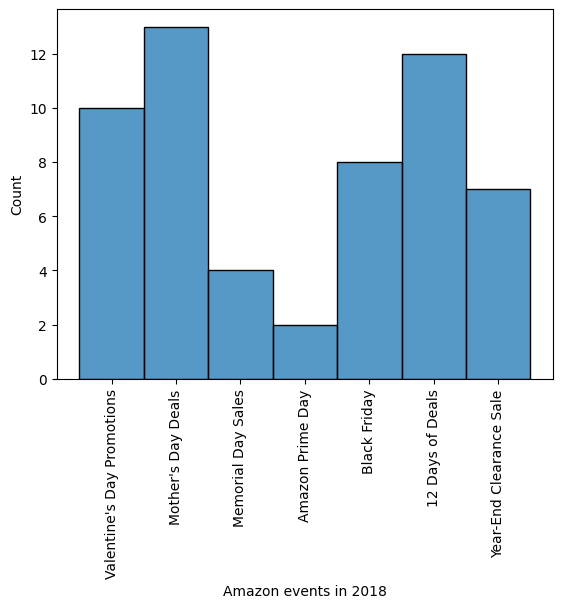

In [584]:
sns.histplot(amazon_events_df[amazon_events_df.index.year==2018], x='Amazon Events')
plt.xticks(rotation=90);
plt.xlabel('Amazon events in 2018')

Text(0.5, 0, 'Amazon events yearly')

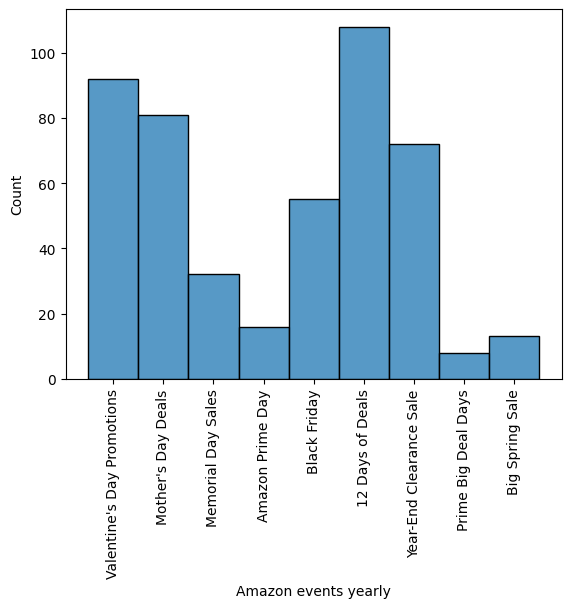

In [585]:
sns.histplot(amazon_events_df, x='Amazon Events')
plt.xticks(rotation=90);
plt.xlabel('Amazon events yearly')

In [586]:
df = pd.merge(df, amazon_events_df, left_index=True, right_index=True, how='left')

In [587]:
df['Amazon Events'].value_counts()

Amazon Events
12 Days of Deals              60
Valentine's Day Promotions    55
Mother's Day Deals            49
Year-End Clearance Sale       39
Black Friday                  34
Memorial Day Sales            20
Amazon Prime Day              10
Prime Big Deal Days            2
Name: count, dtype: int64

In [588]:
df['Amazon Events'] = df['Amazon Events'].fillna('No Events')

Text(0.5, 0, 'Amazon events in 2022')

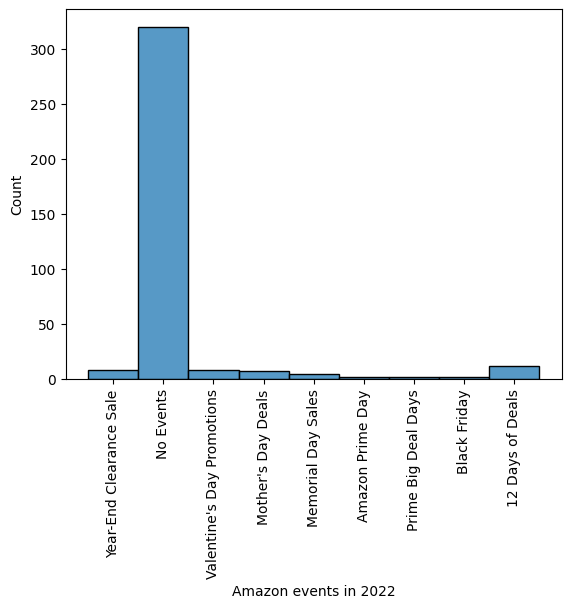

In [589]:
sns.histplot(df[df.index.year==2022], x='Amazon Events')
plt.xticks(rotation=90);
plt.xlabel('Amazon events in 2022')

In [590]:
df = pd.get_dummies(df, drop_first=True)

In [591]:
df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,is_year_end,Amazon Events_Amazon Prime Day,Amazon Events_Black Friday,Amazon Events_Memorial Day Sales,Amazon Events_Mother's Day Deals,Amazon Events_No Events,Amazon Events_Prime Big Deal Days,Amazon Events_Valentine's Day Promotions,Amazon Events_Year-End Clearance Sale
Order Date,,,,,,,,,,,,,,,,,,,,
2018-01-01,16122.06,1,1,2018,False,0,1,1,True,False,True,False,False,False,False,False,True,False,False,False
2018-01-02,17006.00,2,1,2018,False,1,2,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-03,13315.58,3,1,2018,False,2,3,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-04,15820.10,4,1,2018,False,3,4,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-05,17752.51,5,1,2018,False,4,5,1,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,19584.77,27,12,2022,False,1,361,4,False,False,False,False,False,False,False,False,False,False,False,True
2022-12-28,16875.12,28,12,2022,False,2,362,4,False,False,False,False,False,False,False,False,False,False,False,True
2022-12-29,18348.89,29,12,2022,False,3,363,4,False,False,False,False,False,False,False,False,False,False,False,True


**Add holidays**

In [592]:
df = pd.merge(df, holidays['is_holiday'], how='left', left_index=True, right_index=True)
df = add_holidays_past_2021(df)
df['fedral_holiday'] = df['is_holiday'].fillna(False) + df['fedral_holiday'].fillna(False)
df.drop('is_holiday', axis=1,inplace= True)

C:\Users\rohit\AppData\Local\Temp\ipykernel_45600\3289957183.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['fedral_holiday'] = df['is_holiday'].fillna(False) + df['fedral_holiday'].fillna(False)


In [593]:
df['fedral_holiday'].value_counts()

fedral_holiday
False    1740
True       86
Name: count, dtype: int64

**Add inflation**

In [594]:
df = pd.merge(df, inflation_df, left_index=True, right_index=True, how='left')
df['inflation_rate'] = df['inflation_rate'].interpolate()

In [595]:
df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,...,Amazon Events_Amazon Prime Day,Amazon Events_Black Friday,Amazon Events_Memorial Day Sales,Amazon Events_Mother's Day Deals,Amazon Events_No Events,Amazon Events_Prime Big Deal Days,Amazon Events_Valentine's Day Promotions,Amazon Events_Year-End Clearance Sale,fedral_holiday,inflation_rate
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,16122.06,1,1,2018,False,0,1,1,True,False,...,False,False,False,False,True,False,False,False,True,2.040000
2018-01-02,17006.00,2,1,2018,False,1,2,1,False,False,...,False,False,False,False,True,False,False,False,False,2.041935
2018-01-03,13315.58,3,1,2018,False,2,3,1,False,False,...,False,False,False,False,True,False,False,False,False,2.043871
2018-01-04,15820.10,4,1,2018,False,3,4,1,False,False,...,False,False,False,False,True,False,False,False,False,2.045806
2018-01-05,17752.51,5,1,2018,False,4,5,1,False,False,...,False,False,False,False,True,False,False,False,False,2.047742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,19584.77,27,12,2022,False,1,361,4,False,False,...,False,False,False,False,False,False,False,True,False,2.260000
2022-12-28,16875.12,28,12,2022,False,2,362,4,False,False,...,False,False,False,False,False,False,False,True,False,2.260000
2022-12-29,18348.89,29,12,2022,False,3,363,4,False,False,...,False,False,False,False,False,False,False,True,False,2.260000


**Add historic overall sales**

In [596]:
df['Sales 1YA'] = assign_historic_sales(df, year_till=2021)
df['Sales 2YA'] = assign_historic_sales(df, year_till=2020)
df['Sales 3YA'] = assign_historic_sales(df, year_till=2019)

In [597]:
df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,...,Amazon Events_Mother's Day Deals,Amazon Events_No Events,Amazon Events_Prime Big Deal Days,Amazon Events_Valentine's Day Promotions,Amazon Events_Year-End Clearance Sale,fedral_holiday,inflation_rate,Sales 1YA,Sales 2YA,Sales 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,16122.06,1,1,2018,False,0,1,1,True,False,...,False,True,False,False,False,True,2.040000,NaN,NaN,NaN
2018-01-02,17006.00,2,1,2018,False,1,2,1,False,False,...,False,True,False,False,False,False,2.041935,NaN,NaN,NaN
2018-01-03,13315.58,3,1,2018,False,2,3,1,False,False,...,False,True,False,False,False,False,2.043871,NaN,NaN,NaN
2018-01-04,15820.10,4,1,2018,False,3,4,1,False,False,...,False,True,False,False,False,False,2.045806,NaN,NaN,NaN
2018-01-05,17752.51,5,1,2018,False,4,5,1,False,False,...,False,True,False,False,False,False,2.047742,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,19584.77,27,12,2022,False,1,361,4,False,False,...,False,False,False,False,True,False,2.260000,32904.27,28083.85,18605.45
2022-12-28,16875.12,28,12,2022,False,2,362,4,False,False,...,False,False,False,False,True,False,2.260000,28271.32,28408.56,18191.95
2022-12-29,18348.89,29,12,2022,False,3,363,4,False,False,...,False,False,False,False,True,False,2.260000,32067.50,30703.10,19580.33


**Add historic state-wise sales**

In [598]:
def get_shift_value(year, forcast_df=None):
    global df
    if forcast_df is None:
        return (df[df.index.year<2023].index[-1] - df[df.index.year<=year].index[-1]).days
    else:
        return (forcast_df.index[-1] - df[df.index.year<=year].index[-1]).days

In [599]:
def add_states_lags():
    global purchases, df
    temp_df = purchases[['Shipping Address State','Category','total_sales']]
    
    temp_df = pd.DataFrame(temp_df.groupby([temp_df.index,'Shipping Address State'])['total_sales'].sum()).reset_index()
    
    states_features = pd.pivot( temp_df[['Order Date', 'Shipping Address State', 'total_sales']], index='Order Date', columns='Shipping Address State', values='total_sales').reset_index().fillna(0)
    
    states_features = states_features.set_index('Order Date')

    scaler = MinMaxScaler()

    scaled_data = scaler.fit_transform(states_features)
    
    pca = PCA(n_components=3,random_state=101)
    
    pca_features = pca.fit_transform(scaled_data)

    state_sales_reduced = pd.DataFrame(pca_features)

    state_sales_reduced.rename(columns={0:'SS1',1:'SS2',2:'SS3'}, inplace=True)

    state_sales_reduced.set_index(df.index, inplace=True)

    states_features = pd.concat([state_sales_reduced, state_sales_reduced.shift(get_shift_value(2021)-10).rename(columns={'SS1':'SS1 1YA','SS2':'SS2 1YA','SS3':'SS3 1YA'}), state_sales_reduced.shift(get_shift_value(2020)-10).rename(columns={'SS1':'SS1 2YA','SS2':'SS2 2YA','SS3':'SS3 2YA'}), state_sales_reduced.shift(get_shift_value(2019)-10).rename(columns={'SS1':'SS1 3YA','SS2':'SS2 3YA','SS3':'SS3 3YA'})], axis=1)

    return pd.merge(df, states_features, left_index=True, right_index=True, how='left')

In [600]:
get_shift_value(2020)-1

729

In [601]:
df = add_states_lags()

In [602]:
get_null_percentage(df)

total_sales                                  0.000000
day                                          0.000000
month                                        0.000000
year                                         0.000000
is_weekend                                   0.000000
day_of_week                                  0.000000
day_of_year                                  0.000000
quarter                                      0.000000
is_month_start                               0.000000
is_month_end                                 0.000000
is_year_start                                0.000000
is_year_end                                  0.000000
Amazon Events_Amazon Prime Day               0.000000
Amazon Events_Black Friday                   0.000000
Amazon Events_Memorial Day Sales             0.000000
Amazon Events_Mother's Day Deals             0.000000
Amazon Events_No Events                      0.000000
Amazon Events_Prime Big Deal Days            0.000000
Amazon Events_Valentine's Da

## Cross Validation

**generate forcast dataframe**

In [603]:
feature_columns = list(df.columns)
[feature_columns.remove(column) for column in ['total_sales','SS1','SS2','SS3']]
feature_columns

['day',
 'month',
 'year',
 'is_weekend',
 'day_of_week',
 'day_of_year',
 'quarter',
 'is_month_start',
 'is_month_end',
 'is_year_start',
 'is_year_end',
 'Amazon Events_Amazon Prime Day',
 'Amazon Events_Black Friday',
 'Amazon Events_Memorial Day Sales',
 "Amazon Events_Mother's Day Deals",
 'Amazon Events_No Events',
 'Amazon Events_Prime Big Deal Days',
 "Amazon Events_Valentine's Day Promotions",
 'Amazon Events_Year-End Clearance Sale',
 'fedral_holiday',
 'inflation_rate',
 'Sales 1YA',
 'Sales 2YA',
 'Sales 3YA',
 'SS1 1YA',
 'SS2 1YA',
 'SS3 1YA',
 'SS1 2YA',
 'SS2 2YA',
 'SS3 2YA',
 'SS1 3YA',
 'SS2 3YA',
 'SS3 3YA']

In [674]:
forcast_df =  pd.DataFrame(pd.date_range('2023-01-01', '2023-12-31'),columns=['Order Date'])

In [675]:
forcast_df = generate_time_features(forcast_df)

In [676]:
forcast_df = add_holidays_past_2021(forcast_df)

In [677]:
forcast_df['fedral_holiday'] = forcast_df['fedral_holiday'].fillna(False)

C:\Users\rohit\AppData\Local\Temp\ipykernel_45600\2162938522.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  forcast_df['fedral_holiday'] = forcast_df['fedral_holiday'].fillna(False)


In [678]:
forcast_df = add_amazon_events(forcast_df)

In [679]:
forcast_df = forcast_df.drop('index',axis=1)

In [680]:
forcast_df['forcasting'] = True
df['forcasting'] = False

combined_df = pd.concat([df, forcast_df], axis=0)

combined_df['Sales 1YA'] = assign_historic_sales(combined_df, year_till=2022)
combined_df['Sales 2YA'] = assign_historic_sales(combined_df, year_till=2021)
combined_df['Sales 3YA'] = assign_historic_sales(combined_df, year_till=2020)

combined_df[['SS1 1YA','SS2 1YA','SS3 1YA']] = combined_df[['SS1','SS2','SS3']].shift(get_shift_value(2022, forcast_df)-10)
combined_df[['SS1 2YA','SS2 2YA','SS3 2YA']] = combined_df[['SS1','SS2','SS3']].shift(get_shift_value(2021, forcast_df)-10)
combined_df[['SS1 3YA','SS2 3YA','SS3 3YA']] = combined_df[['SS1','SS2','SS3']].shift(get_shift_value(2020, forcast_df)-10)

forcast_df[['Sales 1YA', 'Sales 2YA', 'Sales 3YA','SS1 1YA','SS2 1YA','SS3 1YA','SS1 2YA','SS2 2YA','SS3 2YA','SS1 3YA','SS2 3YA','SS3 3YA']] = combined_df[combined_df['forcasting'] == True][['Sales 1YA', 'Sales 2YA', 'Sales 3YA','SS1 1YA','SS2 1YA','SS3 1YA','SS1 2YA','SS2 2YA','SS3 2YA','SS1 3YA','SS2 3YA','SS3 3YA']]

forcast_df = forcast_df.drop('forcasting',axis=1)
df = df.drop('forcasting',axis=1)

In [681]:
forcast_df['inflation_rate'] = df['inflation_rate'].mean()

In [682]:
forcast_df = pd.concat([df[sorted(feature_columns)].iloc[-30:],forcast_df[sorted(feature_columns)]], axis=0)

In [683]:
forcast_df = forcast_df[feature_columns]

In [684]:
forcast_df

,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,...,Sales 3YA,SS1 1YA,SS2 1YA,SS3 1YA,SS1 2YA,SS2 2YA,SS3 2YA,SS1 3YA,SS2 3YA,SS3 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2022-12-02,2,12,2022,False,4,336,4,False,False,False,...,68580.09,0.390799,-0.084732,0.011374,0.528721,0.111993,-0.014622,0.316070,-0.053215,-0.196227
2022-12-03,3,12,2022,False,5,337,4,False,False,False,...,19426.56,0.589301,-0.070354,-0.148633,0.501165,-0.168356,-0.163615,0.318811,-0.110406,-0.109510
2022-12-04,4,12,2022,True,6,338,4,False,False,False,...,21674.11,0.575905,0.002422,0.037183,0.500846,-0.035116,0.207645,0.312876,0.071322,-0.069005
2022-12-05,5,12,2022,False,0,339,4,False,False,False,...,22322.26,0.781905,0.041588,0.295036,0.476775,0.043697,-0.068057,0.351064,0.116608,-0.166644
2022-12-06,6,12,2022,False,1,340,4,False,False,False,...,24400.10,0.687362,-0.216649,0.221436,0.674633,-0.046609,0.088321,0.400270,0.047092,-0.143028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,27,12,2023,False,2,361,4,False,False,False,...,28083.85,NaN,NaN,NaN,-0.039552,-0.065894,0.009674,0.076311,0.101759,0.266981
2023-12-28,28,12,2023,False,3,362,4,False,False,False,...,28408.56,NaN,NaN,NaN,0.146726,-0.065005,0.080304,0.056957,-0.014689,-0.005521
2023-12-29,29,12,2023,False,4,363,4,False,False,False,...,30703.10,NaN,NaN,NaN,0.105093,-0.020891,0.066558,0.058295,-0.075090,-0.017525


In [685]:
df[feature_columns]

,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,...,Sales 3YA,SS1 1YA,SS2 1YA,SS3 1YA,SS1 2YA,SS2 2YA,SS3 2YA,SS1 3YA,SS2 3YA,SS3 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1,1,2018,False,0,1,1,True,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,2,1,2018,False,1,2,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,3,1,2018,False,2,3,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,4,1,2018,False,3,4,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,5,1,2018,False,4,5,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,27,12,2022,False,1,361,4,False,False,False,...,18605.45,-0.039552,-0.065894,0.009674,0.076311,0.101759,0.266981,-0.066376,-0.165988,-0.427192
2022-12-28,28,12,2022,False,2,362,4,False,False,False,...,18191.95,0.146726,-0.065005,0.080304,0.056957,-0.014689,-0.005521,-0.199835,-0.027518,-0.055484
2022-12-29,29,12,2022,False,3,363,4,False,False,False,...,19580.33,0.105093,-0.020891,0.066558,0.058295,-0.075090,-0.017525,-0.119714,-0.040575,-0.076681


**cross validate**

In [725]:

def cross_validate(df, forcastdf, feature_columns):
    scores = []
    preds = []
    feature_importances = []
    sales = []
    tss = TimeSeriesSplit(n_splits=3, test_size=365, gap=0)
    feature_columns = sorted(feature_columns)
    for train_idx, val_idx in tss.split(df):
        scaler = StandardScaler()
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[feature_columns]
        y_train = train['total_sales']
        X_test = test[feature_columns]
        y_test = test['total_sales']
        reg_model = xgb.XGBRegressor(base_score=0.5, booster='dart',  n_estimators=1000, early_stopping_rounds=50, objective='reg:squarederror', learning_rate=0.01)
        reg_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
        feature_importances.append(reg_model.feature_importances_)
        y_preds = reg_model.predict(X_train)
        ds =  pd.concat([y_train.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        y_preds = reg_model.predict(X_test)
        ds =  pd.concat([y_test.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        forcast_preds = reg_model.predict(forcastdf[feature_columns])
        ds =  pd.Series(forcast_preds, index=forcastdf.index)
        ds.plot(label='prediction')
        plt.legend()
        plt.show()
        preds.append(y_preds)
        score = np.sqrt(mean_squared_error(y_test, y_preds))
        scores.append(score)

    return preds, scores, feature_importances

[0]	validation_0-rmse:16878.52249	validation_1-rmse:25589.69590
[1]	validation_0-rmse:16723.44699	validation_1-rmse:25428.43069
[2]	validation_0-rmse:16569.92894	validation_1-rmse:25265.35116
[3]	validation_0-rmse:16417.95279	validation_1-rmse:25107.54054
[4]	validation_0-rmse:16267.50702	validation_1-rmse:24948.05844
[5]	validation_0-rmse:16118.55323	validation_1-rmse:24793.25367
[6]	validation_0-rmse:15971.09322	validation_1-rmse:24636.44128
[7]	validation_0-rmse:15825.12182	validation_1-rmse:24485.41646
[8]	validation_0-rmse:15680.59769	validation_1-rmse:24331.69816
[9]	validation_0-rmse:15537.51583	validation_1-rmse:24183.19410
[10]	validation_0-rmse:15395.89244	validation_1-rmse:24033.39030
[11]	validation_0-rmse:15255.66704	validation_1-rmse:23887.27860
[12]	validation_0-rmse:15116.84561	validation_1-rmse:23739.97643
[13]	validation_0-rmse:14979.43779	validation_1-rmse:23597.75658
[14]	validation_0-rmse:14843.38502	validation_1-rmse:23453.36137
[15]	validation_0-rmse:14708.69506	

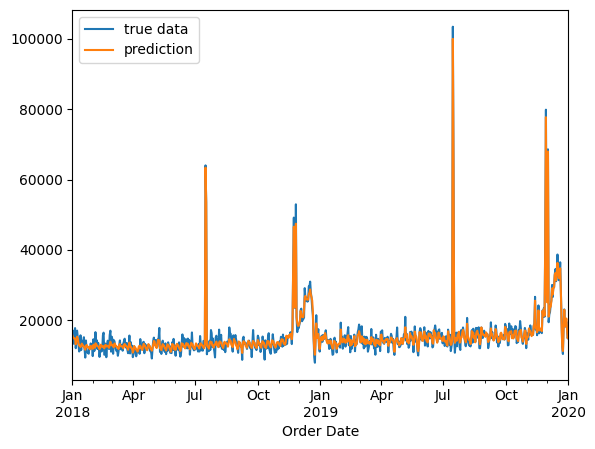

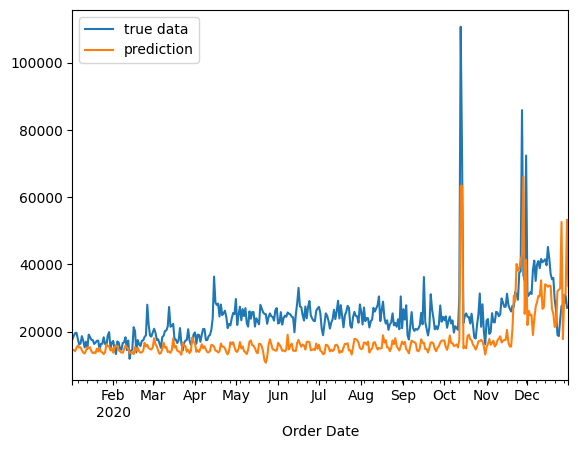

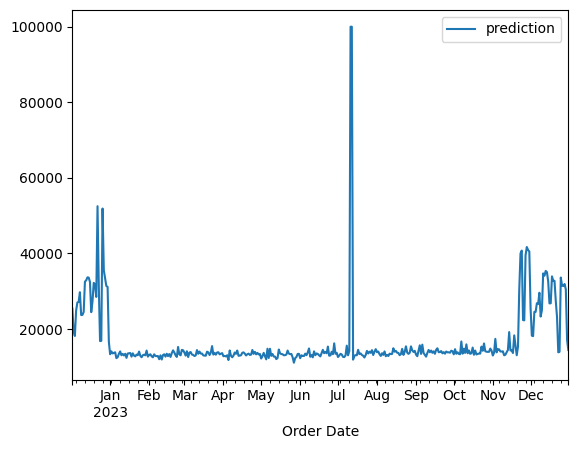

[0]	validation_0-rmse:20170.20733	validation_1-rmse:30283.15675
[1]	validation_0-rmse:19983.62678	validation_1-rmse:30041.68164
[2]	validation_0-rmse:19798.94518	validation_1-rmse:29802.69354
[3]	validation_0-rmse:19616.11334	validation_1-rmse:29567.50644
[4]	validation_0-rmse:19435.13692	validation_1-rmse:29335.23187
[5]	validation_0-rmse:19255.96915	validation_1-rmse:29109.35278
[6]	validation_0-rmse:19078.62310	validation_1-rmse:28880.37118
[7]	validation_0-rmse:18903.05980	validation_1-rmse:28659.11169
[8]	validation_0-rmse:18729.25559	validation_1-rmse:28439.60306
[9]	validation_0-rmse:18557.22276	validation_1-rmse:28218.87835
[10]	validation_0-rmse:18386.91305	validation_1-rmse:28003.79406
[11]	validation_0-rmse:18218.33493	validation_1-rmse:27791.43154
[12]	validation_0-rmse:18051.45657	validation_1-rmse:27575.99182
[13]	validation_0-rmse:17886.27294	validation_1-rmse:27367.95677
[14]	validation_0-rmse:17722.82629	validation_1-rmse:27162.12155
[15]	validation_0-rmse:17560.96363	

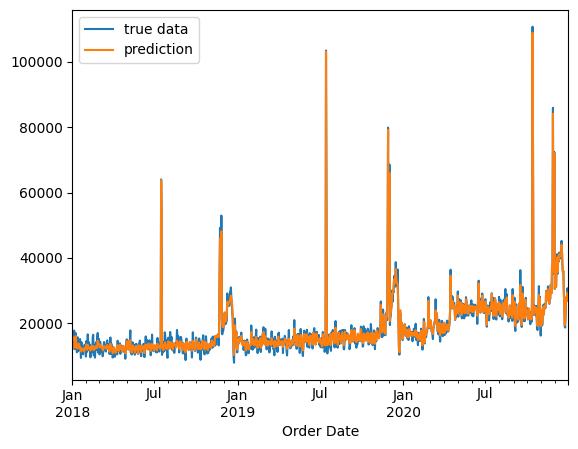

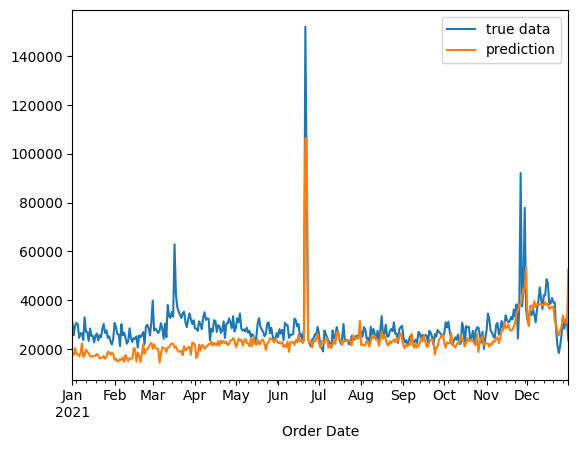

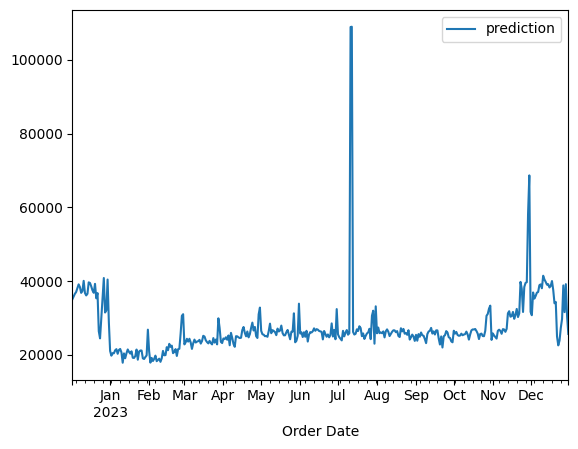

[0]	validation_0-rmse:23100.49589	validation_1-rmse:29681.50864
[1]	validation_0-rmse:22884.89968	validation_1-rmse:29412.14796
[2]	validation_0-rmse:22671.44565	validation_1-rmse:29146.32268
[3]	validation_0-rmse:22460.19176	validation_1-rmse:28882.66338
[4]	validation_0-rmse:22251.03753	validation_1-rmse:28622.47551
[5]	validation_0-rmse:22044.00047	validation_1-rmse:28365.06773
[6]	validation_0-rmse:21839.10215	validation_1-rmse:28109.76336
[7]	validation_0-rmse:21636.26825	validation_1-rmse:27856.95683
[8]	validation_0-rmse:21435.45667	validation_1-rmse:27607.49402
[9]	validation_0-rmse:21236.68538	validation_1-rmse:27360.71075
[10]	validation_0-rmse:21039.96564	validation_1-rmse:27115.68277
[11]	validation_0-rmse:20845.20800	validation_1-rmse:26873.91082
[12]	validation_0-rmse:20652.46899	validation_1-rmse:26634.40219
[13]	validation_0-rmse:20461.65136	validation_1-rmse:26397.82051
[14]	validation_0-rmse:20272.77738	validation_1-rmse:26163.80067
[15]	validation_0-rmse:20085.86310	

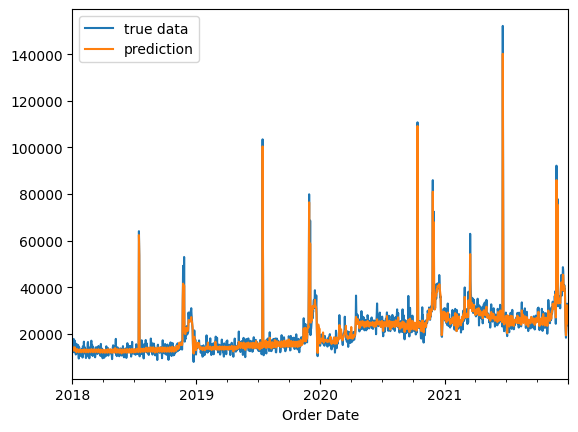

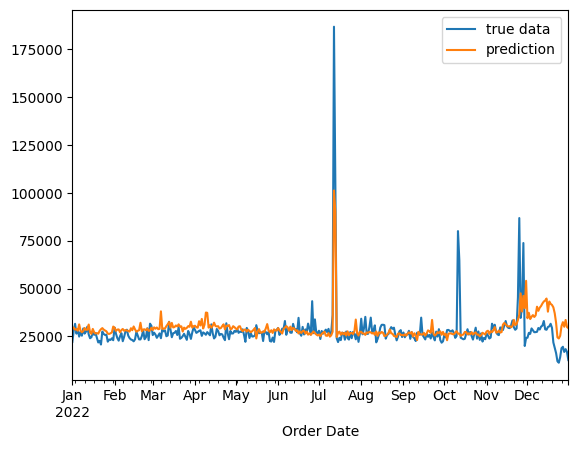

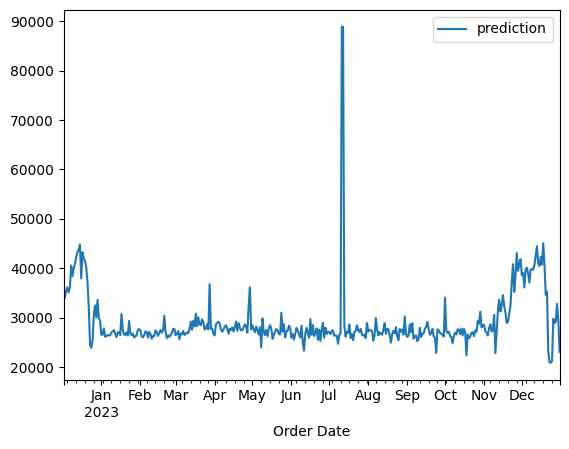

In [726]:
preds, scores, feature_importances = cross_validate(df, forcast_df, feature_columns)

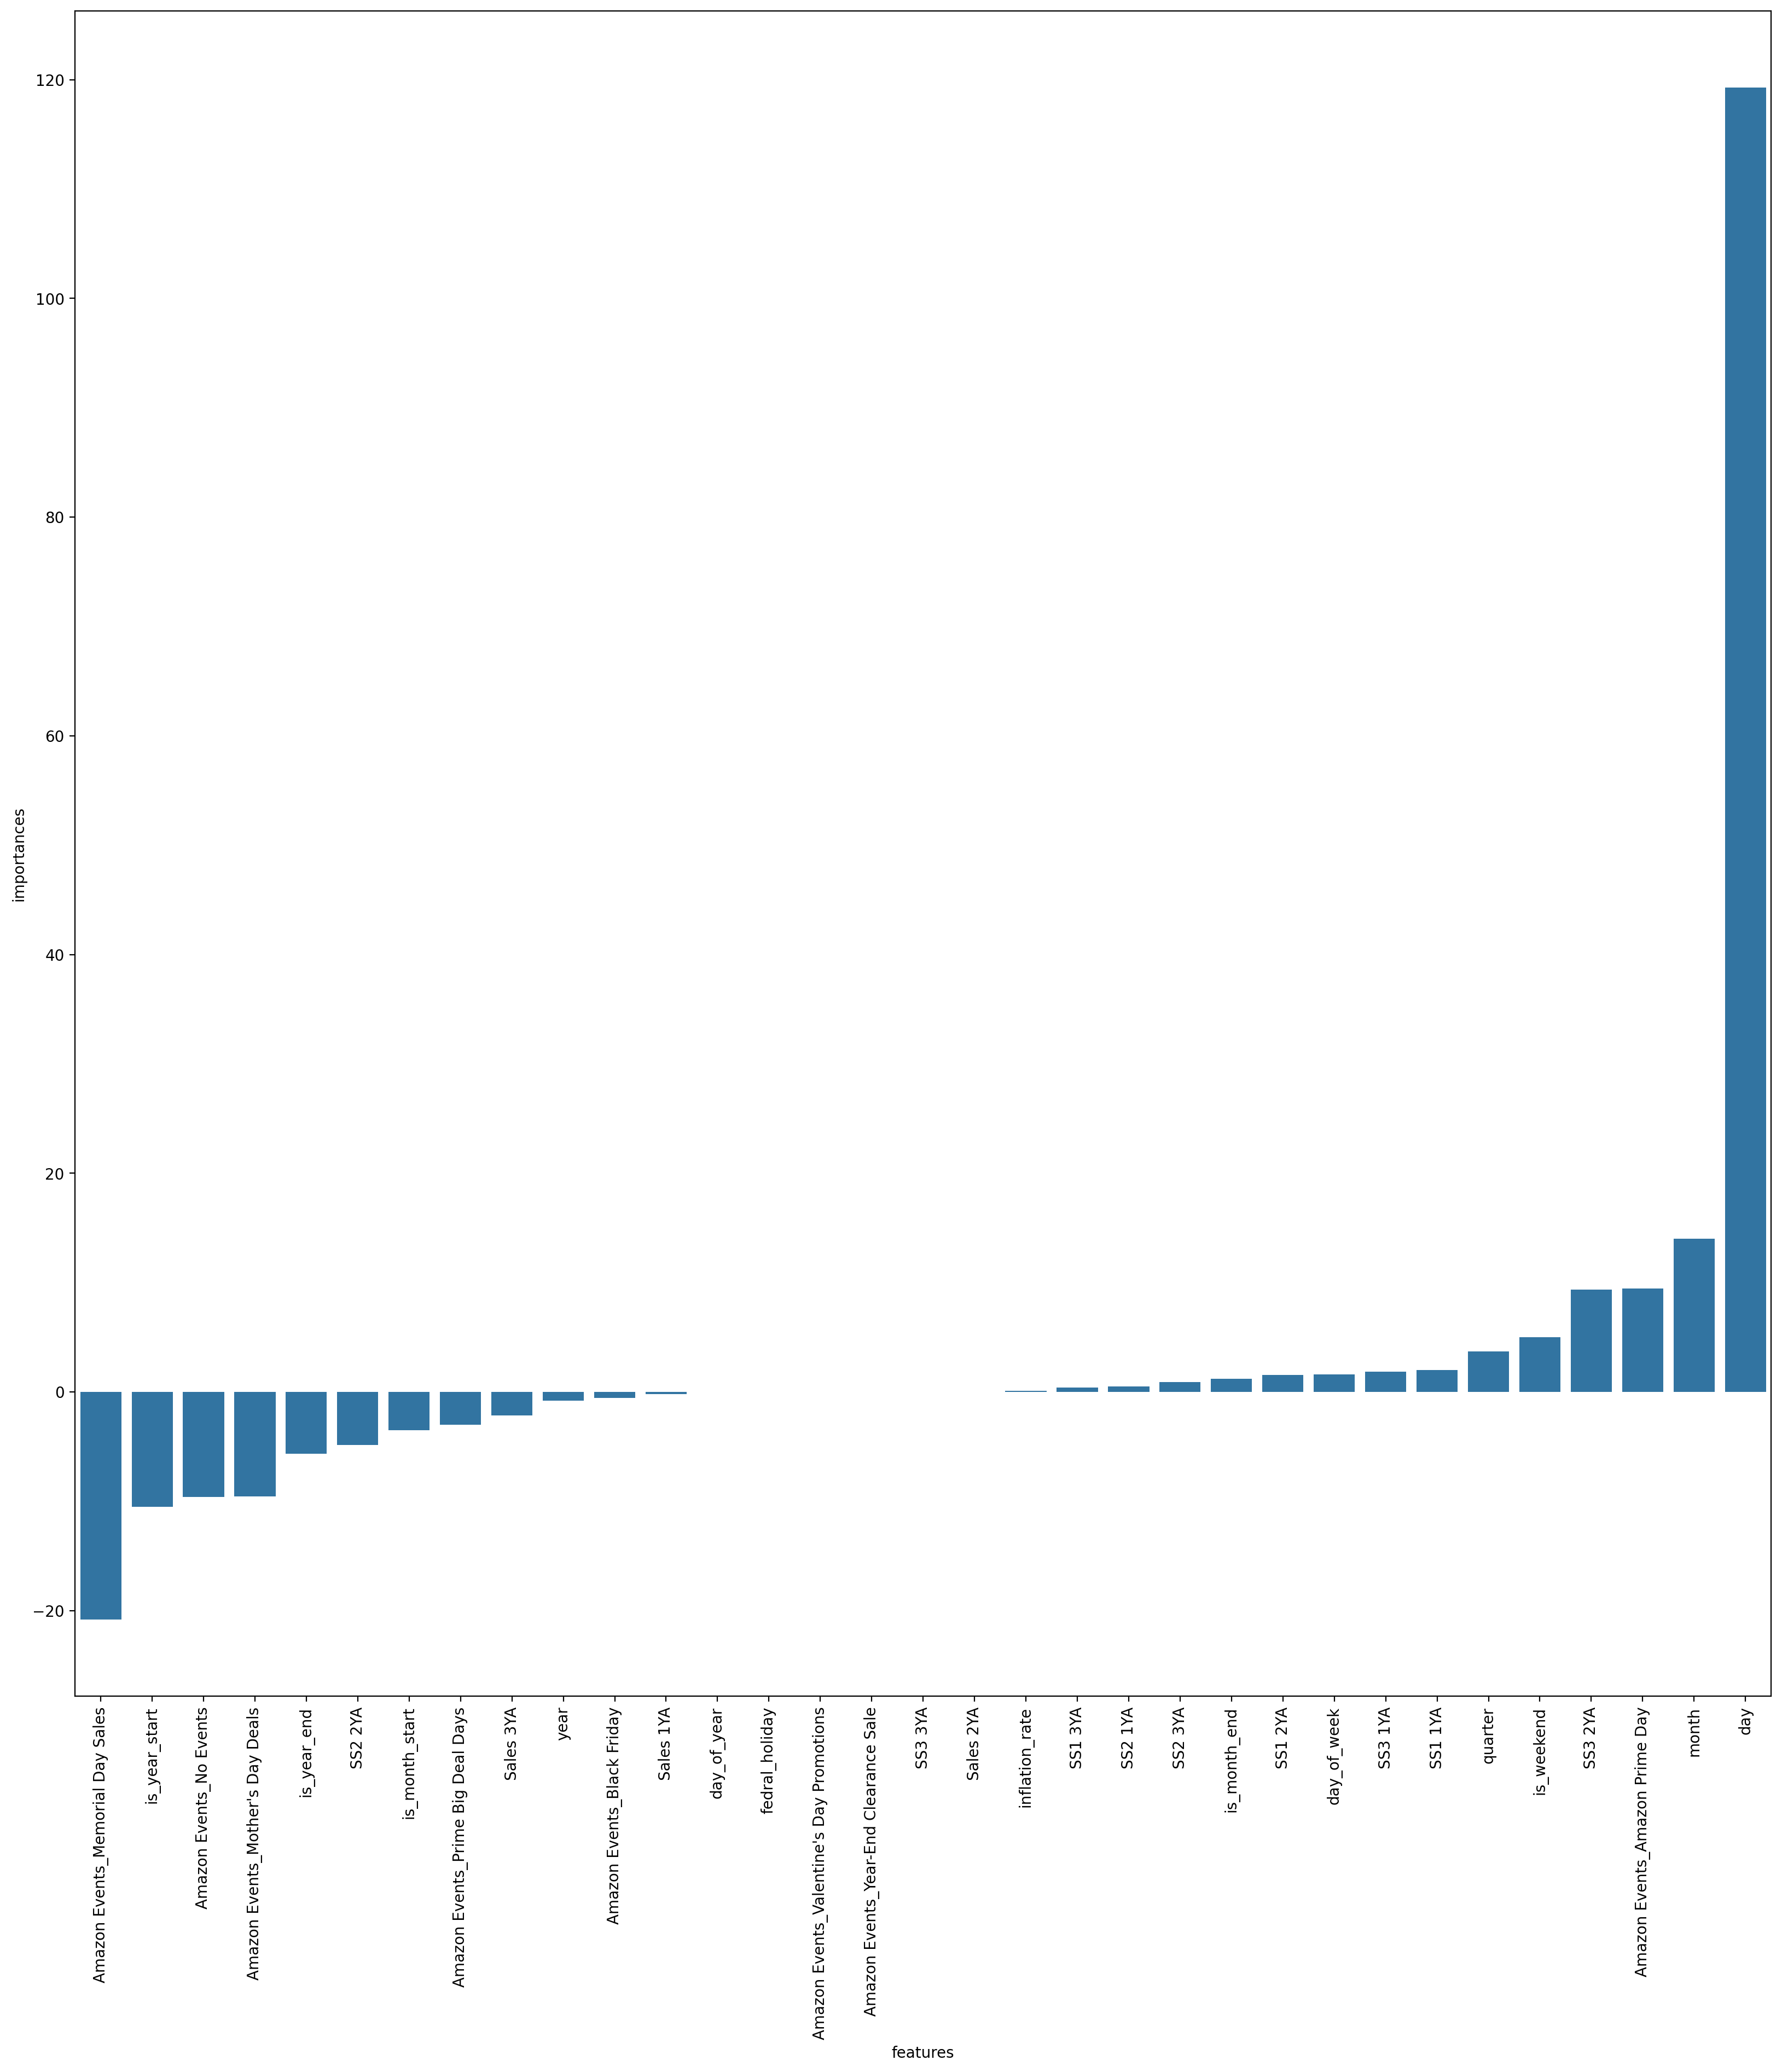

In [619]:
feature_importances_df = pd.DataFrame([feature_columns, feature_importances[-1]*100]).transpose().sort_values(by=1).rename(columns={0:'features',1:'importances'})

plt.figure(figsize=(20,20), dpi=200)
sns.barplot(feature_importances_df, x = 'features', y = 'importances')
plt.xticks(rotation=90);

In [55]:
int(np.sum(preds[0]))

7997

## XGBOOST Train with full data

In [637]:
scores = []
for i in range(1000):
    reg_model = xgb.XGBRegressor(base_score=0.5, booster='gblinear',  n_estimators=i, early_stopping_rounds=50, objective='reg:squarederror', learning_rate=0.01)
    reg_model.fit(df[feature_columns], df['total_sales'], eval_set=[(df[feature_columns], df['total_sales'])], verbose=False)
    y_preds = reg_model.predict(df[feature_columns])
    scores.append(np.sqrt(mean_squared_error(df['total_sales'], y_preds)))
    

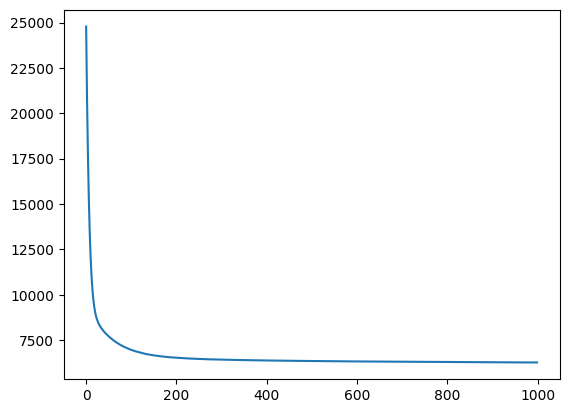

In [639]:
plt.plot(range(1000),scores)

In [640]:
scores[400:]

[np.float64(6375.107435633661),
 np.float64(6374.606908632479),
 np.float64(6374.2599209459795),
 np.float64(6373.865050021139),
 np.float64(6373.503602954897),
 np.float64(6373.100314198607),
 np.float64(6372.695575350607),
 np.float64(6372.386293220836),
 np.float64(6371.670185590288),
 np.float64(6371.854483687182),
 np.float64(6371.458874144544),
 np.float64(6371.237006548261),
 np.float64(6370.758376339412),
 np.float64(6370.466964836048),
 np.float64(6369.8402034294),
 np.float64(6369.733309508927),
 np.float64(6369.375274772412),
 np.float64(6368.995189533247),
 np.float64(6368.784198302864),
 np.float64(6368.1101937368285),
 np.float64(6368.028140921627),
 np.float64(6367.772972372049),
 np.float64(6367.5177772201205),
 np.float64(6367.200866036203),
 np.float64(6366.512280048282),
 np.float64(6365.962865350157),
 np.float64(6365.8285155793055),
 np.float64(6365.838459405231),
 np.float64(6364.88218499518),
 np.float64(6364.898269517093),
 np.float64(6364.723156279277),
 np.flo

In [672]:
reg_model = xgb.XGBRegressor(base_score=0.5, booster='gblinear',  n_estimators=400, early_stopping_rounds=50, objective='reg:squarederror', learning_rate=0.01)
reg_model.fit(df[feature_columns], df['total_sales'], eval_set=[(df[feature_columns], df['total_sales'])], verbose=False)

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

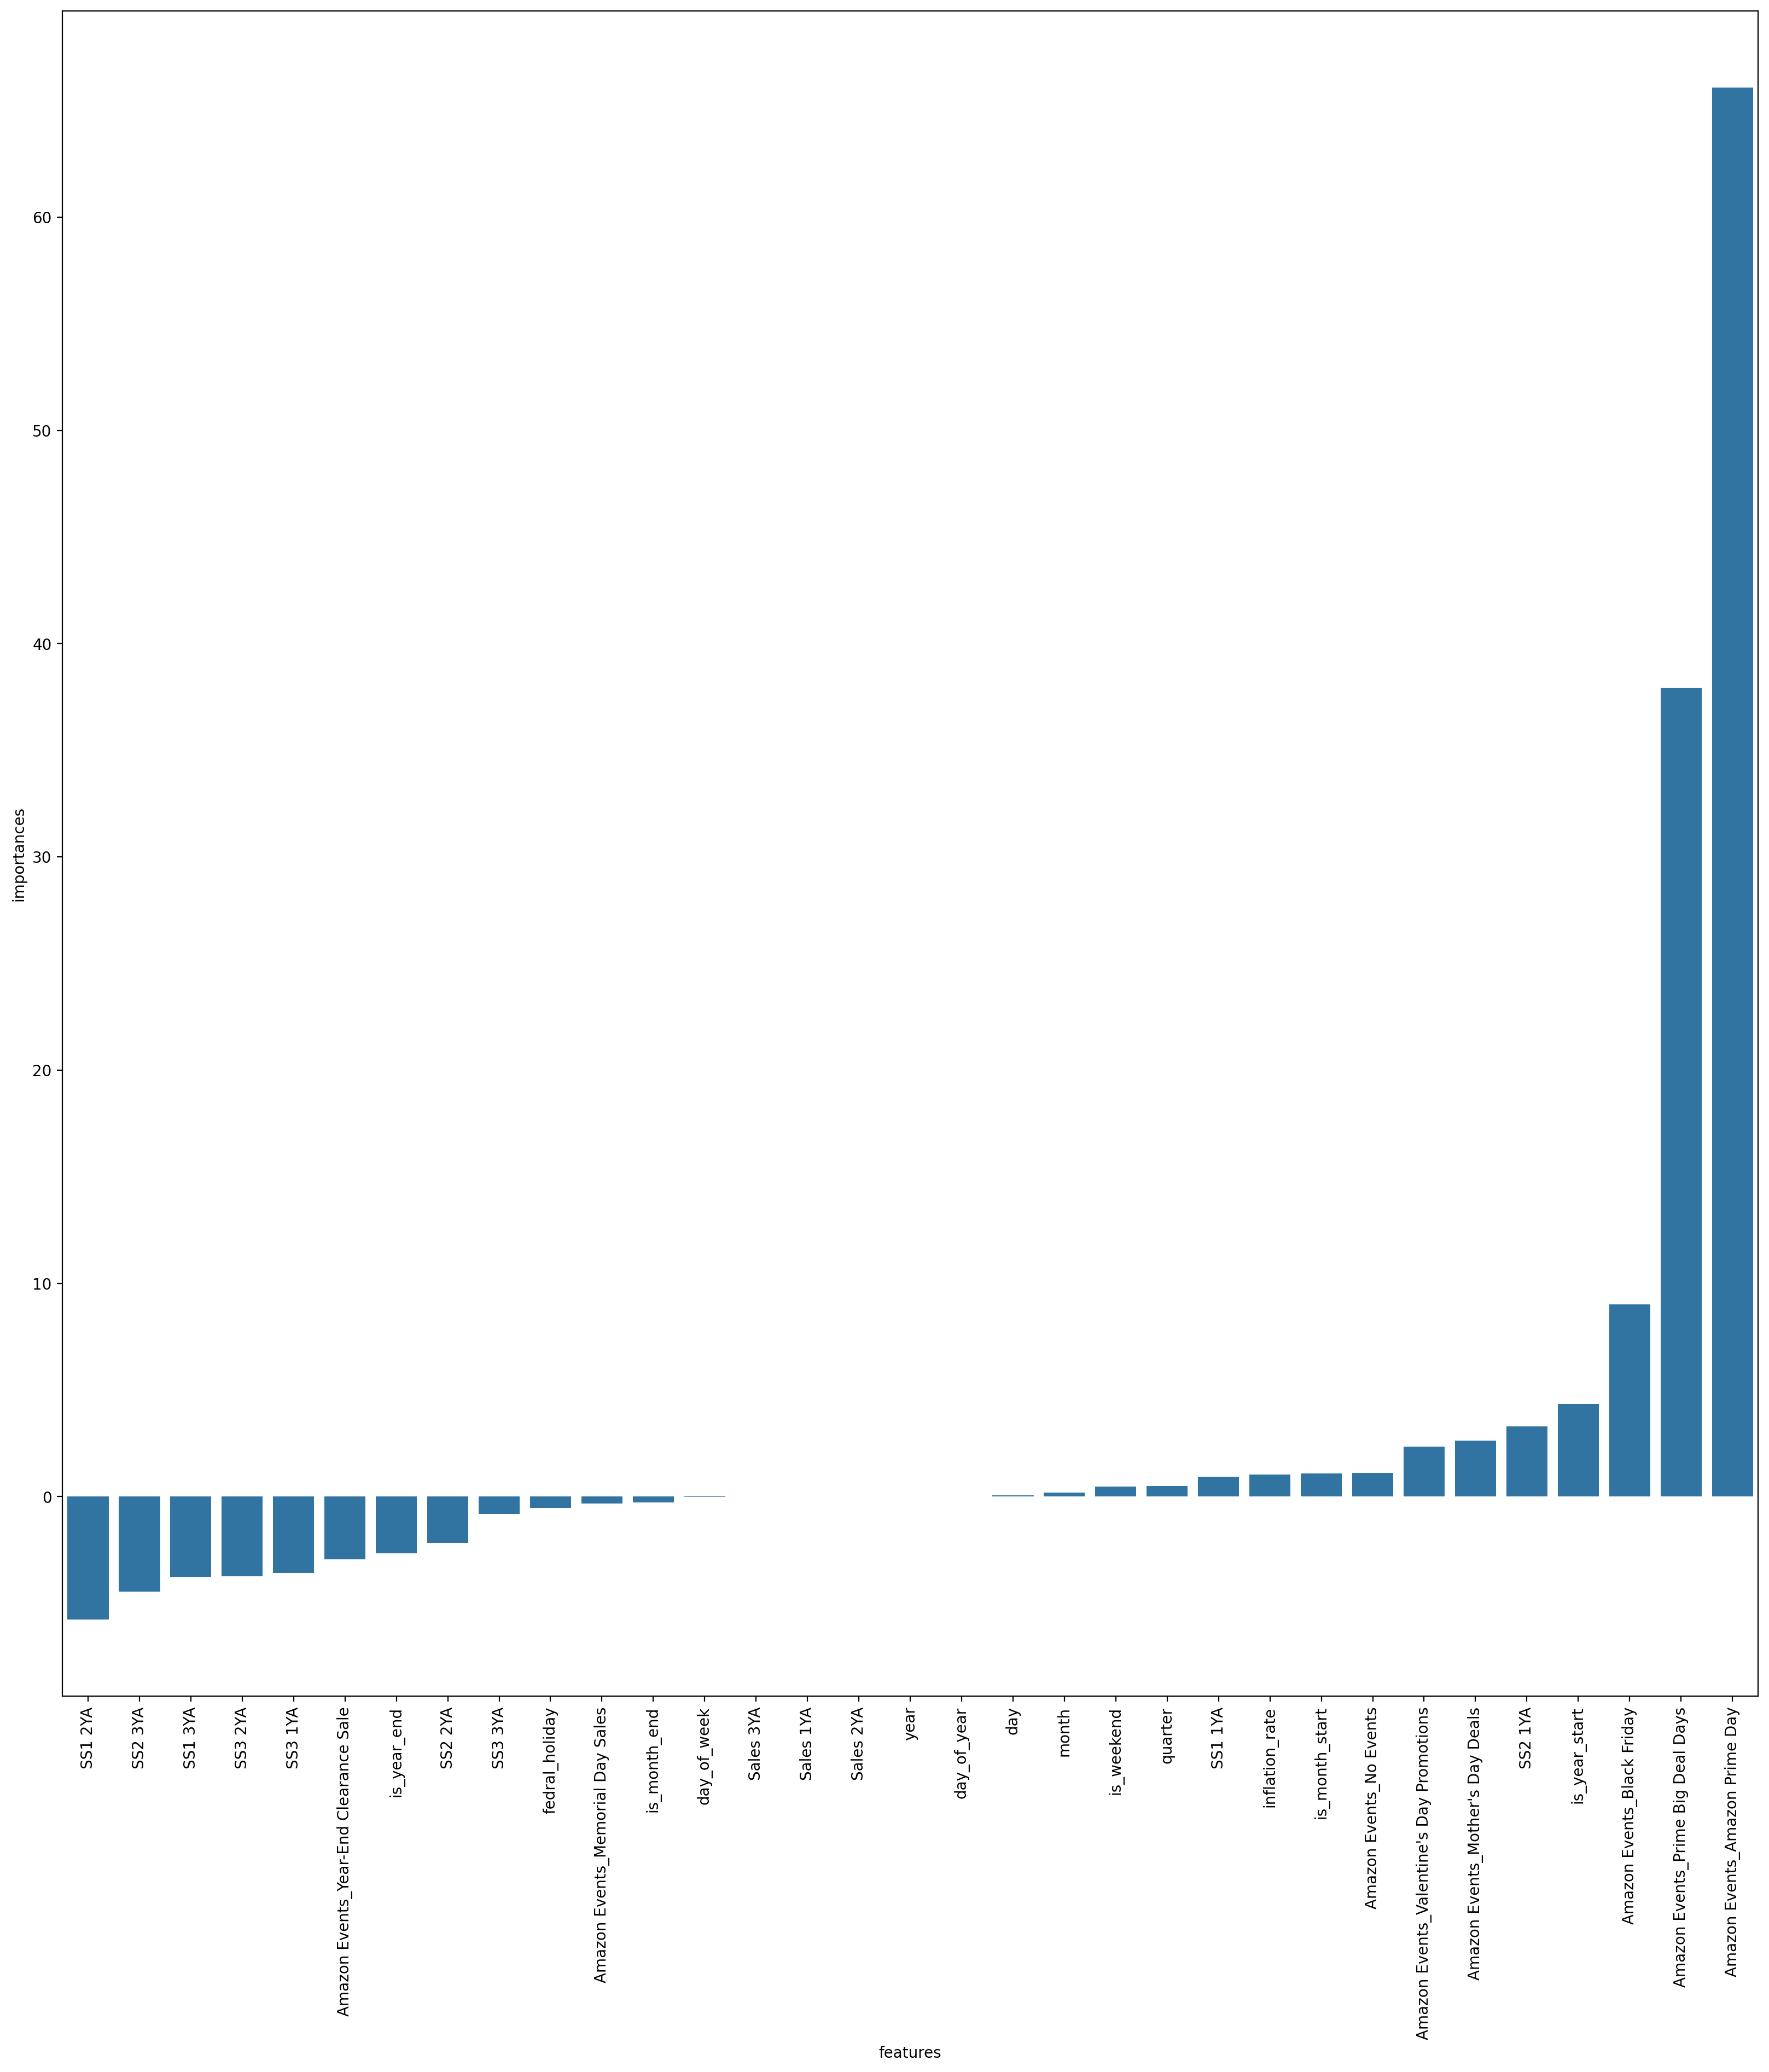

In [673]:
feature_importances_df = pd.DataFrame([feature_columns, reg_model.feature_importances_*100]).transpose().sort_values(by=1).rename(columns={0:'features',1:'importances'})

plt.figure(figsize=(20,20), dpi=200)
sns.barplot(feature_importances_df, x = 'features', y = 'importances')
plt.xticks(rotation=90);

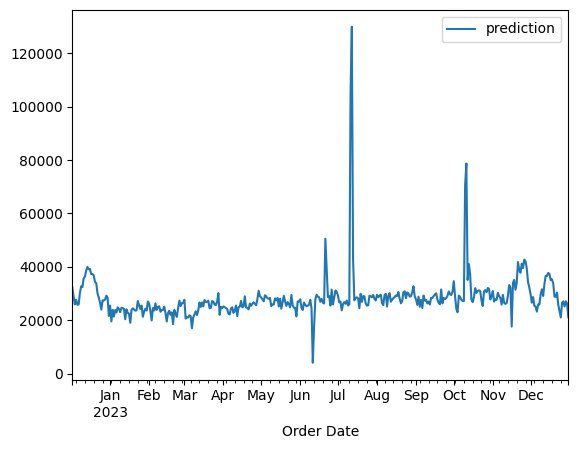

In [686]:
y_preds = reg_model.predict(forcast_df[feature_columns])
ds =  pd.Series(y_preds, index=forcast_df.index)
ds.plot(label='prediction')
plt.legend()
plt.show()

# AdaBoost

In [704]:
def cross_validate(df, forcastdf, feature_columns):
    scores = []
    preds = []
    feature_importances = []
    sales = []
    tss = TimeSeriesSplit(n_splits=3, test_size=365, gap=0)
    feature_columns = sorted(feature_columns)
    for train_idx, val_idx in tss.split(df):
        scaler = StandardScaler()
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[feature_columns]
        y_train = train['total_sales']
        X_test = test[feature_columns]
        y_test = test['total_sales']
        reg_model = AdaBoostRegressor(random_state=101, n_estimators=33)
        reg_model.fit(X_train, y_train)
        feature_importances.append(reg_model.feature_importances_)
        y_preds = reg_model.predict(X_train)
        ds =  pd.concat([y_train.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        y_preds = reg_model.predict(X_test)
        ds =  pd.concat([y_test.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        forcast_preds = reg_model.predict(forcastdf[feature_columns])
        ds =  pd.Series(forcast_preds, index=forcastdf.index)
        ds.plot(label='prediction')
        plt.legend()
        plt.show()
        preds.append(y_preds)
        score = np.sqrt(mean_squared_error(y_test, y_preds))
        scores.append(score)

    return preds, scores, feature_importances

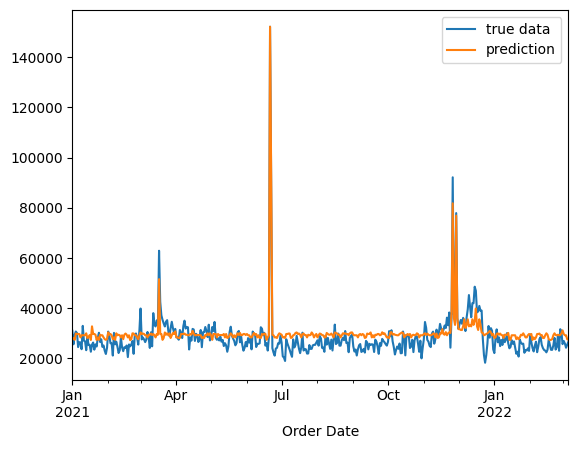

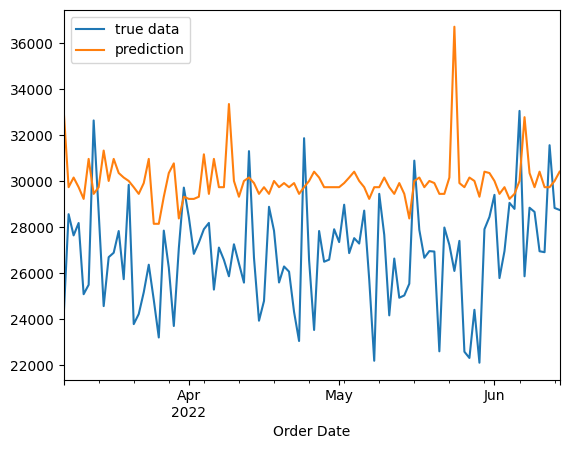

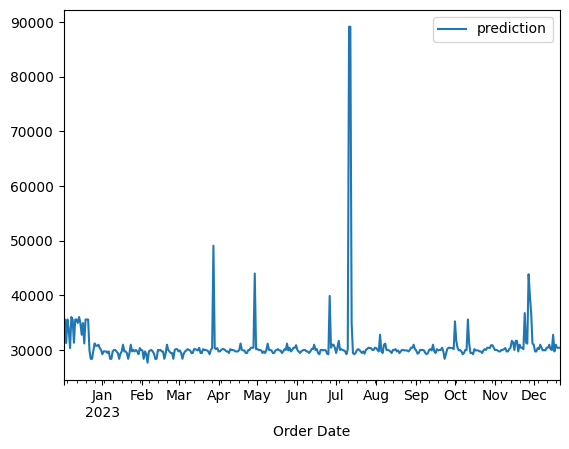

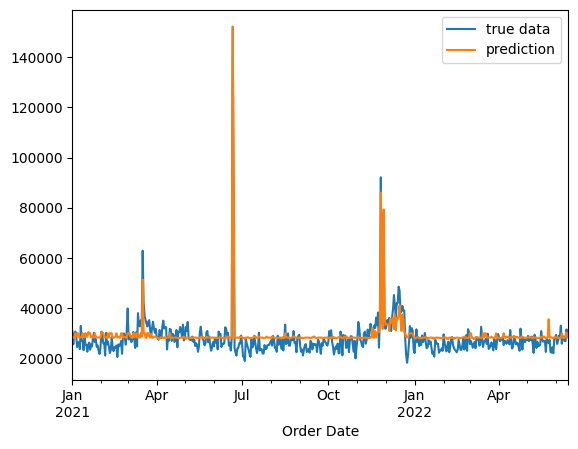

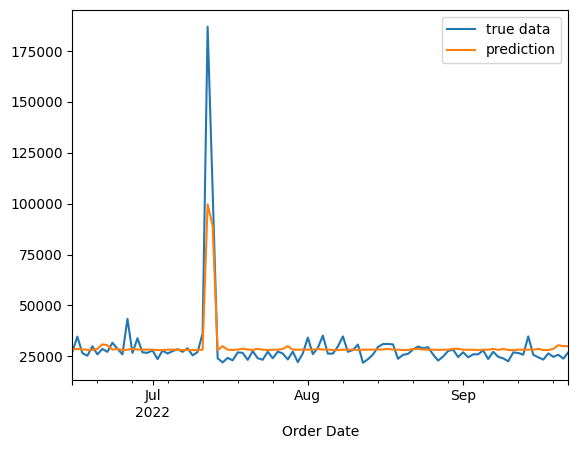

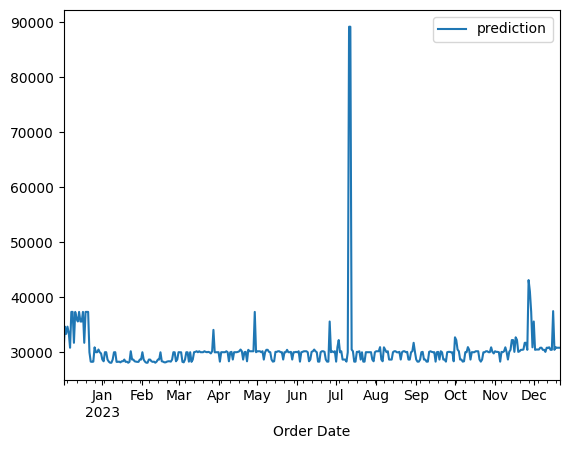

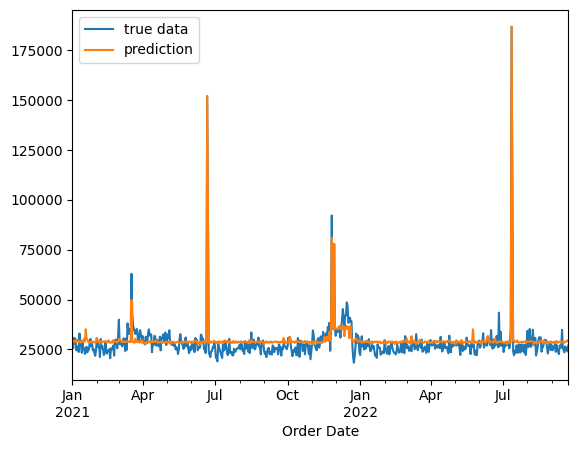

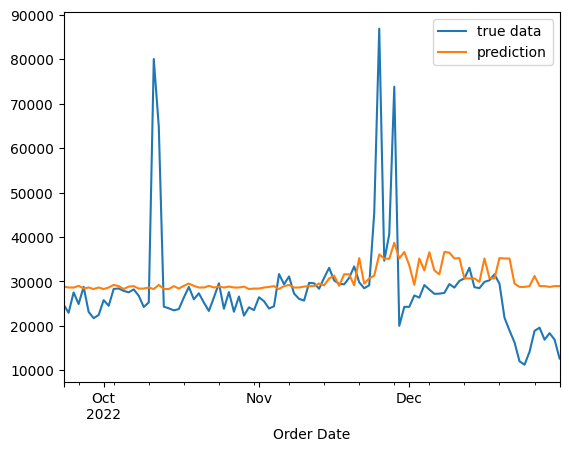

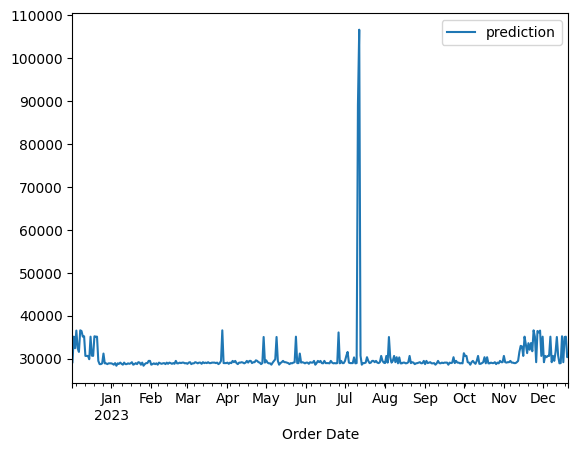

In [705]:
preds, scores, feature_importances = cross_validate(df, forcast_df, feature_columns)

In [718]:
df['Sales 2YA'].interpolate()

Order Date
2018-01-01         NaN
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
                ...   
2022-12-27    28083.85
2022-12-28    28408.56
2022-12-29    30703.10
2022-12-30    27021.29
2022-12-31    27404.00
Name: Sales 2YA, Length: 1826, dtype: float64

In [712]:
from sklearn.impute import SimpleImputer

In [713]:
si = SimpleImputer()

In [730]:
df.columns


Index(['total_sales', 'day', 'month', 'year', 'is_weekend', 'day_of_week',
       'day_of_year', 'quarter', 'is_month_start', 'is_month_end',
       'is_year_start', 'is_year_end', 'Amazon Events_Amazon Prime Day',
       'Amazon Events_Black Friday', 'Amazon Events_Memorial Day Sales',
       'Amazon Events_Mother's Day Deals', 'Amazon Events_No Events',
       'Amazon Events_Prime Big Deal Days',
       'Amazon Events_Valentine's Day Promotions',
       'Amazon Events_Year-End Clearance Sale', 'fedral_holiday',
       'inflation_rate', 'Sales 1YA', 'Sales 2YA', 'Sales 3YA', 'SS1', 'SS2',
       'SS3', 'SS1 1YA', 'SS2 1YA', 'SS3 1YA', 'SS1 2YA', 'SS2 2YA', 'SS3 2YA',
       'SS1 3YA', 'SS2 3YA', 'SS3 3YA'],
      dtype='object')

In [732]:
forcast_df.columns

Index(['day', 'month', 'year', 'is_weekend', 'day_of_week', 'day_of_year',
       'quarter', 'is_month_start', 'is_month_end', 'is_year_start',
       'is_year_end', 'Amazon Events_Amazon Prime Day',
       'Amazon Events_Black Friday', 'Amazon Events_Memorial Day Sales',
       'Amazon Events_Mother's Day Deals', 'Amazon Events_No Events',
       'Amazon Events_Prime Big Deal Days',
       'Amazon Events_Valentine's Day Promotions',
       'Amazon Events_Year-End Clearance Sale', 'fedral_holiday',
       'inflation_rate', 'Sales 1YA', 'Sales 2YA', 'Sales 3YA', 'SS1 1YA',
       'SS2 1YA', 'SS3 1YA', 'SS1 2YA', 'SS2 2YA', 'SS3 2YA', 'SS1 3YA',
       'SS2 3YA', 'SS3 3YA'],
      dtype='object')

In [7]:
a = xgb.XGBRegressor()

In [8]:
a.load_model('model.json')

In [10]:
a.feature_importances_

array([ 7.16183007e-01,  1.00121222e-01,  1.34780323e-02,  4.11578208e-01,
       -2.63185315e-02,  9.55101661e-03, -6.28875345e-02, -4.06190529e-02,
        3.46795060e-02, -2.33463179e-02, -4.69702445e-02, -3.91566753e-02,
       -4.21438664e-02, -1.26665672e-02,  1.56305498e-06,  1.86965212e-06,
        1.22625431e-06,  5.99192223e-04, -1.31369830e-04,  5.83852670e-05,
       -8.48749932e-03,  1.10914595e-02, -3.02365050e-03,  1.12145552e-02,
        4.71268501e-03, -2.89591458e-02,  1.41542368e-02,  1.95109739e-03,
        5.31978719e-03,  1.35047885e-05], dtype=float32)

In [ ]:
pd.w